In [1]:
# 추가되는 패키지는 여기에서 import 해주세요
import warnings
warnings.filterwarnings('ignore')

import missingno
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopy.distance
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns',500)

import numpy as np
import datetime
import statsmodels.api as sm

pd.set_option('display.max_colwidth', -1)

In [6]:
# 데이터 load
train = pd.read_csv('train.csv', date_parser='date')
train.tail()
weather = pd.read_csv('jejuweather.csv')

In [8]:
# 분석을 위해 컬럼명 수정
train.rename(columns={'6~7_ride': 'ride6', '7~8_ride': 'ride7', '8~9_ride': 'ride8',\
                      '9~10_ride': 'ride9', '10~11_ride': 'ride10', '11~12_ride': 'ride11', 
                      '6~7_takeoff': 'off6', '7~8_takeoff': 'off7', '8~9_takeoff': 'off8', \
                      '9~10_takeoff': 'off9', '10~11_takeoff': 'off10', '11~12_takeoff': 'off11',\
                      '18~20_ride': 'ride18'},inplace=True)
# date 타입 변경
train['date'] = train['date'].astype('datetime64')
# 9월 1일 ~ 9월 30일 데이터이니까, day만 따로 가져옴
train['date_day'] = train['date'].dt.day
# 월(0) ~ 일(6) 데이터로 변환
train['date_dayofweek'] = train['date'].dt.dayofweek
train['date_dayofname']= train['date'].dt.weekday_name
crowded_codes = list(train[train['ride18'] > 15]['station_code'].unique())
train['crowded'] = [1 if x in crowded_codes else 0 for x in train.station_code]
train['weekend'] = [1 if x[0] == 'S' else 0 for x in list(train.date_dayofname)]


weather['date'] = weather['date'].astype('datetime64')
weather.columns 
train = pd.merge(train, weather, on= 'date')

In [10]:
train.rename(columns={'amount of precipitation' : 'precipitation',
                      'wind speed':'wind_speed',
                      'atmospheric pressure':'atmospheric_pressure'},inplace=True)
train.fillna(0, inplace = True) #강수량 0(최빈값으로)


### top 10에서의 거리

In [11]:
def get_distance(coords):
    distances = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords).km for i in range(len(train))]
    return distances

In [12]:
coords = {
'coords_jeju_uni' : (33.45589,126.55984), #제주대학교의 위도 경도
'coords_jeju_city1' : (33.49891,126.52822), #제주시청(광양방면)의 위도 경도
'coords_halla_hospital' : (33.48552,126.47533), #한라병원의 위도 경도
'coords_jeju_city2' : (33.49954,126.52765), #제주시청(아라방면)
'coords_jeju_rotary' : (33.51241,126.52595), #동문로터리(동문시장)의 위도 경도
'coords_jeju_bt' : (33.50298,126.49516), #제주버스터미널
'coords_jeju_airpt1' : (33.50618,126.49307), #제주국제공항(구제주방면)
'coords_nh' : (33.48493,126.47812), # 노형오거리의 위도 경도
'coords_jeju_airpt2' : (33.50650,126.49303), # 제주국제공항(신제주방면):
'coords_jejusi' : (33.500770, 126.522761), #제주시의 위도 경도
'coords_seoquipo' : (33.259429, 126.558217) #서귀포시의 위도 경도   
}

for i,j in coords.items():
    train[i] = get_distance(j)

In [14]:
latitdue_3 = 33.3736664
longitude_3 = [train.longitude.quantile(0.2),train.longitude.quantile(0.8)]

geo_code = []
for lat, lon in list(zip(train.latitude, train.longitude)):
    if (lat >= latitdue_3 and lon <= longitude_3[0]):
        geo_code.append(0)
    elif (lat >= latitdue_3 and lon <= longitude_3[1]):
        geo_code.append(1)
    elif (lat >= latitdue_3 and lon >= longitude_3[1]):
        geo_code.append(2)
    elif (lat < latitdue_3 and lon <= longitude_3[0]):
        geo_code.append(3)
    elif (lat < latitdue_3 and lon <= longitude_3[1]):
        geo_code.append(4)
    elif (lat < latitdue_3 and lon >= longitude_3[1]):
        geo_code.append(5)

train['geo_code'] = geo_code

In [18]:
center_coords = {'center_0' : tuple(list(train[train.geo_code == 0].sort_values('ride18', ascending = False)[['latitude','longitude']].iloc[0])),
'center_1' : tuple(list(train[train.geo_code == 1].sort_values('ride18', ascending = False)[['latitude','longitude']].iloc[0])), 
'center_2' : tuple(list(train[train.geo_code == 2].sort_values('ride18', ascending = False)[['latitude','longitude']].iloc[0])),
'center_3' : tuple(list(train[train.geo_code == 3].sort_values('ride18', ascending = False)[['latitude','longitude']].iloc[0])),
'center_4' : tuple(list(train[train.geo_code == 4].sort_values('ride18', ascending = False)[['latitude','longitude']].iloc[0])),
'center_5' : tuple(list(train[train.geo_code == 5].sort_values('ride18', ascending = False)[['latitude','longitude']].iloc[0]))}

for i,j in center_coords.items():
    train[i] = get_distance(j)

### station_code별 통계량

### 범주화 가능한 변수들
-weekend, crowded

### 지역별 통계량


In [130]:
a.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', 'ride6', 'ride7', 'ride8', 'ride9', 'ride10',
       'ride11', 'off6', 'off7', 'off8', 'off9', 'off10', 'off11', 'ride18',
       'date_day', 'date_dayofweek', 'date_dayofname', 'temperature',
       'precipitation', 'wind_speed', 'humidity', 'atmospheric_pressure',
       'coords_jeju_airpt1', 'coords_nh', 'coords_jeju_city1',
       'coords_jeju_rotary', 'coords_seoquipo', 'coords_jeju_bt',
       'coords_halla_hospital', 'coords_jeju_airpt2', 'coords_jejusi',
       'coords_jeju_city2', 'coords_jeju_uni', 'geo_code', 'center_3',
       'center_1', 'center_5', 'center_0', 'center_4', 'center_2', 'crowded',
       'weekend'],
      dtype='object')

In [113]:
[x[0] for x in list(train.date_dayofname)]

['S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S',
 'S'

In [117]:
train.to_csv('data.csv')

In [126]:
cols = list(train.columns)
cate = ['in_out','geo_code','crowded','weekend']
[cols.remove(cat) for cat in cate]
unnecessary = ['id','date','bus_route_id','station_code','station_name','latitude','longitude','date_day','date_dayofname','ride18']
[cols.remove(un) for un in unnecessary]
var = cols
# var.remove('precipitation')
var_scale = ["scale({})".format(name) for name in var]
var_scale

train1 = train[train.ride18 != 0]
train0 = train[train.ride18 == 0]

idx = np.random.choice(range(len(train0)), size = int(len(train1)*0.7))
train_00 = train0.iloc[idx]
# len(train_00)
a = pd.concat([train1,train_00] , axis = 0)


['scale(ride6)',
 'scale(ride7)',
 'scale(ride8)',
 'scale(ride9)',
 'scale(ride10)',
 'scale(ride11)',
 'scale(off6)',
 'scale(off7)',
 'scale(off8)',
 'scale(off9)',
 'scale(off10)',
 'scale(off11)',
 'scale(date_dayofweek)',
 'scale(temperature)',
 'scale(precipitation)',
 'scale(wind_speed)',
 'scale(humidity)',
 'scale(atmospheric_pressure)',
 'scale(coords_jeju_airpt1)',
 'scale(coords_nh)',
 'scale(coords_jeju_city1)',
 'scale(coords_jeju_rotary)',
 'scale(coords_seoquipo)',
 'scale(coords_jeju_bt)',
 'scale(coords_halla_hospital)',
 'scale(coords_jeju_airpt2)',
 'scale(coords_jejusi)',
 'scale(coords_jeju_city2)',
 'scale(coords_jeju_uni)',
 'scale(center_3)',
 'scale(center_1)',
 'scale(center_5)',
 'scale(center_0)',
 'scale(center_4)',
 'scale(center_2)']

In [129]:
model = sm.OLS.from_formula(
    'ride18 ~C(weekend):C(geo_code) + C(crowded) +'+'+'.join(var_scale), data=a)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 ride18   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     3753.
Date:                Thu, 26 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:29:53   Log-Likelihood:            -6.0228e+05
No. Observations:              202121   AIC:                         1.205e+06
Df Residuals:                  202073   BIC:                         1.205e+06
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [152]:
a

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,date_day,date_dayofweek,date_dayofname,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,coords_jeju_airpt1,coords_nh,coords_jeju_city1,coords_jeju_rotary,coords_seoquipo,coords_jeju_bt,coords_halla_hospital,coords_jeju_airpt2,coords_jejusi,coords_jeju_city2,coords_jeju_uni,geo_code,center_3,center_1,center_5,center_0,center_4,center_2,crowded,weekend
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,1.999639,0.817689,4.144260,4.573099,26.403025,1.769946,1.005035,2.031282,3.720275,4.111514,7.882664,1,37.432854,2.057088,31.926457,8.860019,27.170571,10.398404,1,1
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,3.256777,0.550025,5.425714,5.937689,25.893305,3.091514,0.444545,3.284238,5.036124,5.401146,8.523410,1,36.128972,3.316057,32.081940,7.613648,26.664580,11.502675,1,1
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,0.068407,2.670840,3.403386,3.192192,27.997494,0.394882,2.756127,0.093815,2.864166,3.336603,8.352000,1,39.319506,0.127071,32.810019,10.138360,28.760559,9.877884,1,1
6,6,2019-09-01,4270000,시외,1660,제주국제컨벤션센터중문대포해안주상절리대,33.24309,126.42472,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,3.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,29.864766,27.279230,29.963516,31.320669,12.571534,29.560626,27.297574,29.898651,30.000531,30.012709,26.743874,3,15.985383,29.918902,27.929694,25.076477,12.779731,31.658265,1,1
8,8,2019-09-01,4270000,시외,1726,강정농협,33.23603,126.47827,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,29.994266,27.605724,29.524531,30.973065,7.889399,29.649398,27.672512,30.029550,29.653075,29.585249,25.539653,4,20.764894,30.043551,23.162544,26.877166,7.967298,30.177431,1,1
12,12,2019-09-01,4270000,시외,2014,하얏트호텔,33.24511,126.40579,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,30.073073,27.437240,30.367490,31.684945,14.292620,29.785251,27.438276,30.106240,30.373034,30.412439,27.425060,3,14.327003,30.128546,29.644220,24.709149,14.522789,32.398187,1,1
13,13,2019-09-01,4270000,시외,2094,한국콘도입구,33.25024,126.41022,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,29.414867,26.785736,29.685782,31.007562,13.828503,29.124715,26.789407,29.448143,29.694567,29.731162,26.724306,3,14.880967,29.470164,29.163302,24.164076,14.086614,31.696028,1,1
15,15,2019-09-01,4270000,시외,2114,스위트호텔,33.24904,126.40767,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,29.606147,26.971801,29.897726,31.215296,14.075851,29.317853,26.973485,29.639336,29.903332,29.942674,26.961965,3,14.615045,29.661583,29.415026,24.282724,14.327716,31.937759,1,1
16,16,2019-09-01,4270000,시내,2494,동광환승정류장5(서귀방면),33.30958,126.34083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,6.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,26.000312,23.267391,27.291475,28.329982,21.000075,25.811152,23.180963,26.028047,27.130766,27.311465,26.050077,3,13.393868,26.059544,35.568630,18.200525,21.480723,31.061561,1,1
20,20,2019-09-01,4270000,시내,2851,제주월드컵경기장(600번),33.24911,126.50907,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,10.0,1.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,28.550787,26.313155,27.762852,29.245142,4.720561,28.186754,26.407814,28.586425,27.940961,27.829238,23.415932,4,23.824792,28.596596,20.064138,26.522924,4.890625,27.859936,1,1


In [153]:
train['ride18'].describe()

count    415423.000000
mean     1.242095     
std      4.722287     
min      0.000000     
25%      0.000000     
50%      0.000000     
75%      1.000000     
max      272.000000   
Name: ride18, dtype: float64

In [56]:
train = pd.read_csv('train.csv')

In [57]:
tt = train.groupby('station_code').mean().reset_index().sort_values('ride18', ascending = False)

KeyError: 'ride18'

In [58]:
tt

NameError: name 'tt' is not defined

In [165]:
ttt = tt[['station_code','ride6','ride7','ride8','ride9','ride10','ride11','off6','off7','off8','off9','off10','off11','ride18']]

In [174]:
train = train.merge(ttt, on = 'station_code')

In [175]:
train.to_csv('data2.csv')

In [177]:
cols

['ride6_x',
 'ride7',
 'ride8_x',
 'ride9_x',
 'ride10_x',
 'ride11_x',
 'off6_x',
 'off7_x',
 'off8_x',
 'off9_x',
 'off10_x',
 'off11_x',
 'ride18_x',
 'date_dayofweek',
 'temperature',
 'precipitation',
 'wind_speed',
 'humidity',
 'atmospheric_pressure',
 'coords_jeju_airpt1',
 'coords_nh',
 'coords_jeju_city1',
 'coords_jeju_rotary',
 'coords_seoquipo',
 'coords_jeju_bt',
 'coords_halla_hospital',
 'coords_jeju_airpt2',
 'coords_jejusi',
 'coords_jeju_city2',
 'coords_jeju_uni',
 'center_3',
 'center_1',
 'center_5',
 'center_0',
 'center_4',
 'center_2',
 'ride6_y',
 'ride6_y',
 'ride8_y',
 'ride9_y',
 'ride10_y',
 'ride11_y',
 'off6_y',
 'off7_y',
 'off8_y',
 'off9_y',
 'off10_y',
 'off11_y',
 'ride18_y']

In [352]:
cols = list(train.columns)
cate = ['in_out','geo_code','crowded','weekend']
[cols.remove(cat) for cat in cate]
unnecessary = ['addr','city','road_addr','id','date','bus_route_id','station_code','station_name','latitude','longitude','date_dayofname','date_day','date_dayofweek','ride18_x','ride18_y']
[cols.remove(un) for un in unnecessary]
var = cols
# var.remove('precipitation')
var_scale = ["scale({})".format(name) for name in var]
var_scale



['scale(ride6_x)',
 'scale(ride7)',
 'scale(ride8_x)',
 'scale(ride9_x)',
 'scale(ride10_x)',
 'scale(ride11_x)',
 'scale(off6_x)',
 'scale(off7_x)',
 'scale(off8_x)',
 'scale(off9_x)',
 'scale(off10_x)',
 'scale(off11_x)',
 'scale(temperature)',
 'scale(precipitation)',
 'scale(wind_speed)',
 'scale(humidity)',
 'scale(atmospheric_pressure)',
 'scale(coords_jeju_airpt1)',
 'scale(coords_nh)',
 'scale(coords_jeju_city1)',
 'scale(coords_jeju_rotary)',
 'scale(coords_seoquipo)',
 'scale(coords_jeju_bt)',
 'scale(coords_halla_hospital)',
 'scale(coords_jeju_airpt2)',
 'scale(coords_jejusi)',
 'scale(coords_jeju_city2)',
 'scale(coords_jeju_uni)',
 'scale(center_3)',
 'scale(center_1)',
 'scale(center_5)',
 'scale(center_0)',
 'scale(center_4)',
 'scale(center_2)',
 'scale(ride6_y)',
 'scale(ride6_y)',
 'scale(ride8_y)',
 'scale(ride9_y)',
 'scale(ride10_y)',
 'scale(ride11_y)',
 'scale(off6_y)',
 'scale(off7_y)',
 'scale(off8_y)',
 'scale(off9_y)',
 'scale(off10_y)',
 'scale(off11_y)']

In [353]:

train1 = train[train.ride18_x != 0]
train0 = train[train.ride18_x == 0]

idx = np.random.choice(range(len(train0)), size = int(len(train1)*0.7))
train_00 = train0.iloc[idx]
# len(train_00)
a = pd.concat([train1,train_00] , axis = 0)

In [354]:
a.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', 'ride6_x', 'ride7', 'ride8_x', 'ride9_x',
       'ride10_x', 'ride11_x', 'off6_x', 'off7_x', 'off8_x', 'off9_x',
       'off10_x', 'off11_x', 'ride18_x', 'date_day', 'date_dayofweek',
       'date_dayofname', 'temperature', 'precipitation', 'wind_speed',
       'humidity', 'atmospheric_pressure', 'coords_jeju_airpt1', 'coords_nh',
       'coords_jeju_city1', 'coords_jeju_rotary', 'coords_seoquipo',
       'coords_jeju_bt', 'coords_halla_hospital', 'coords_jeju_airpt2',
       'coords_jejusi', 'coords_jeju_city2', 'coords_jeju_uni', 'geo_code',
       'center_3', 'center_1', 'center_5', 'center_0', 'center_4', 'center_2',
       'crowded', 'weekend', 'ride6_y', 'ride6_y', 'ride8_y', 'ride9_y',
       'ride10_y', 'ride11_y', 'off6_y', 'off7_y', 'off8_y', 'off9_y',
       'off10_y', 'off11_y', 'ride18_y', 'city', 'addr', 'road_addr'],
      dtype='object')

In [358]:
model = sm.OLS.from_formula(
    'ride18_x ~ C(addr) + C(weekend) + C(geo_code) + C(crowded) +'+'+'.join(var_scale), data=a)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               ride18_x   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     1621.
Date:                Thu, 26 Mar 2020   Prob (F-statistic):               0.00
Time:                        19:27:01   Log-Likelihood:            -5.9630e+05
No. Observations:              202121   AIC:                         1.193e+06
Df Residuals:                  201997   BIC:                         1.194e+06
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [357]:
len( a.addr.unique())

72

In [320]:
X = a[var]
X

,ride6_x,ride7,ride8_x,ride9_x,ride10_x,ride11_x,off6_x,off7_x,off8_x,off9_x,off10_x,off11_x,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,coords_jeju_airpt1,coords_nh,coords_jeju_city1,coords_jeju_rotary,coords_seoquipo,coords_jeju_bt,coords_halla_hospital,coords_jeju_airpt2,coords_jejusi,coords_jeju_city2,coords_jeju_uni,center_3,center_1,center_5,center_0,center_4,center_2,ride6_y,ride6_y,ride6_y,ride6_y,ride8_y,ride9_y,ride10_y,ride11_y,off6_y,off7_y,off8_y,off9_y,off10_y,off11_y,ride18_y
1,1.0,8.0,3.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,24.1,25.7,2.4,93.8,1012.5,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
4,2.0,4.0,8.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,26.2,7.0,1.6,89.3,1008.1,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
6,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.6,34.3,6.5,80.0,998.4,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
10,2.0,5.0,3.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,5.0,1.8,88.5,1012.0,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
11,1.0,1.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.1,0.6,3.2,86.3,1012.0,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
12,0.0,1.0,3.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,3.0,73.4,1010.4,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
13,0.0,1.0,2.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,24.3,0.0,2.1,76.5,1009.7,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
15,3.0,4.0,3.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,24.6,0.0,1.9,82.8,1007.8,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
17,3.0,1.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,23.3,0.0,2.4,69.9,1013.7,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
18,3.0,4.0,2.0,2.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,22.8,0.0,3.2,65.9,1014.3,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.21

## 잔차와 변수

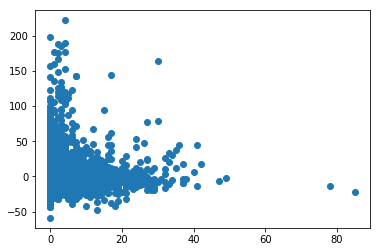

In [310]:
plt.scatter((X[X.columns[0]]),result.resid)
plt.show()


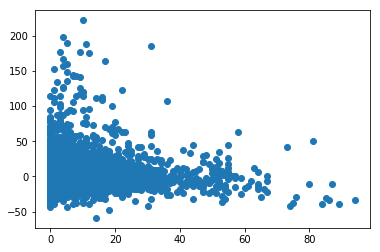

In [294]:
plt.scatter(X[X.columns[1]], result.resid)
plt.show()

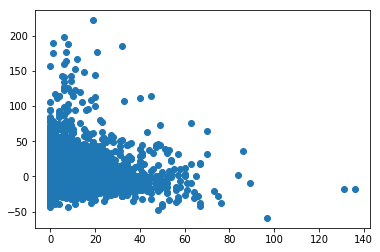

In [295]:
plt.scatter(X[X.columns[2]], result.resid)
plt.show()

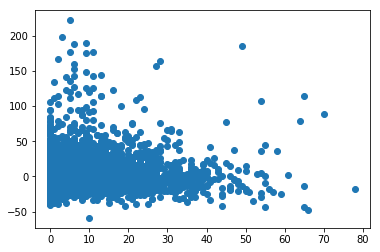

In [296]:
plt.scatter(X[X.columns[3]], result.resid)
plt.show()

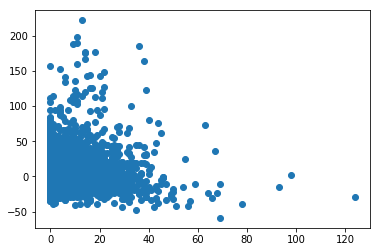

In [297]:
plt.scatter(X[X.columns[4]], result.resid)
plt.show()

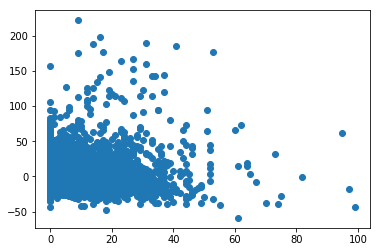

In [298]:
plt.scatter(X[X.columns[5]], result.resid)
plt.show()

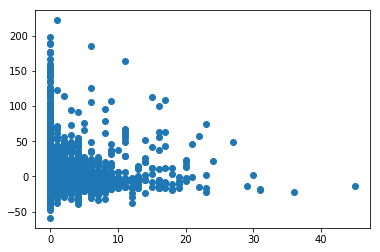

In [299]:
plt.scatter(X[X.columns[6]], result.resid)
plt.show()

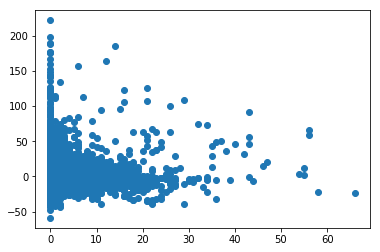

In [300]:
plt.scatter(X[X.columns[7]], result.resid)
plt.show()

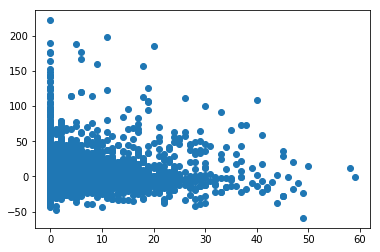

In [301]:
plt.scatter(X[X.columns[8]], result.resid)
plt.show()

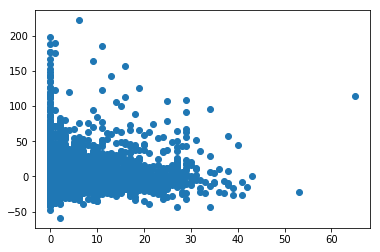

In [311]:
plt.scatter(X[X.columns[9]], result.resid)
plt.show()

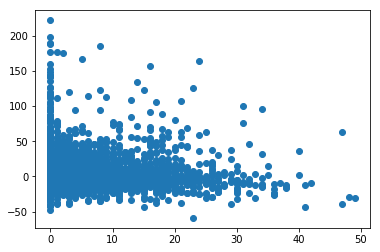

In [312]:
plt.scatter(X[X.columns[10]], result.resid)
plt.show()

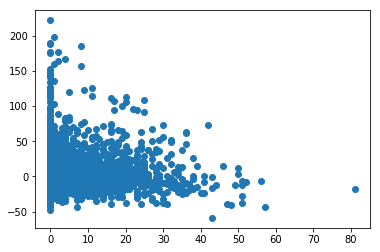

In [313]:
plt.scatter(X[X.columns[11]], result.resid)
plt.show()

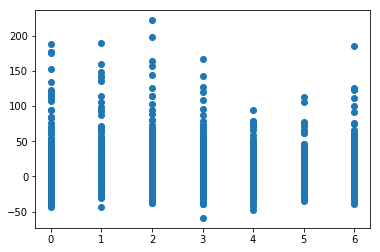

In [314]:
plt.scatter(X[X.columns[12]], result.resid)
plt.show()

In [315]:
X

,ride6_x,ride7,ride8_x,ride9_x,ride10_x,ride11_x,off6_x,off7_x,off8_x,off9_x,off10_x,off11_x,date_dayofweek,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,coords_jeju_airpt1,coords_nh,coords_jeju_city1,coords_jeju_rotary,coords_seoquipo,coords_jeju_bt,coords_halla_hospital,coords_jeju_airpt2,coords_jejusi,coords_jeju_city2,coords_jeju_uni,center_3,center_1,center_5,center_0,center_4,center_2,ride6_y,ride6_y,ride6_y,ride6_y,ride8_y,ride9_y,ride10_y,ride11_y,off6_y,off7_y,off8_y,off9_y,off10_y,off11_y,ride18_y
1,1.0,8.0,3.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0,24.1,25.7,2.4,93.8,1012.5,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
4,2.0,4.0,8.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3,26.2,7.0,1.6,89.3,1008.1,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
6,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,27.6,34.3,6.5,80.0,998.4,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
10,2.0,5.0,3.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2,26.0,5.0,1.8,88.5,1012.0,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
11,1.0,1.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,24.1,0.6,3.2,86.3,1012.0,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
12,0.0,1.0,3.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,24.0,0.0,3.0,73.4,1010.4,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
13,0.0,1.0,2.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,5,24.3,0.0,2.1,76.5,1009.7,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
15,3.0,4.0,3.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0,24.6,0.0,1.9,82.8,1007.8,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
17,3.0,1.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,2,23.3,0.0,2.4,69.9,1013.7,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777683,1.842310,2.954920,3.328526,7.210437,37.935883,1.853545,31.415850,9.648904,27.021098,9.594762,1.633333,1.633333,1.633333,1.633333,2.733333,2.433333,2.333333,2.100000,0.000000,0.166667,0.000000,0.100000,0.133333,0.166667,1.466667
18,3.0,4.0,2.0,2.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,3,22.8,0.0,3.2,65.9,1014.3,1.806711,1.551929,3.357284,3.898320,26.256744,1.456820,1.777

In [194]:
X = a[var]
len(X.columns)

50

In [197]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=len(X.columns)-1)
X_low = pca1.fit_transform(X)
X_low = pd.DataFrame(X_low)

new_cols = []
for i in range(len(X_low.columns)):
    new_cols.append('comp{}'.format(i))
X_low.columns = new_cols

var = list(X_low.columns)
# var.remove('precipitation')
var_scale = ["scale({})".format(name) for name in var]
var_scale


NameError: name 'df' is not defined

In [203]:
X_low

,comp0,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,comp9,comp10,comp11,comp12,comp13,comp14,comp15,comp16,comp17,comp18,comp19,comp20,comp21,comp22,comp23,comp24,comp25,comp26,comp27,comp28,comp29,comp30,comp31,comp32,comp33,comp34,comp35,comp36,comp37,comp38,comp39,comp40,comp41,comp42,comp43,comp44,comp45,comp46,comp47,comp48
0,-39.158846,9.900453,-3.529326,2.272725,-9.182890,4.810707,-2.299432,3.245104,-4.756751,-1.276070,-0.402871,-2.763089,-3.352349,1.283731,-1.242635,1.660527,-2.509733,0.480209,-1.177289,0.040142,-1.152500,-0.495352,0.652646,0.405481,2.887213,0.426627,-0.465570,-1.286768,0.348836,-0.630650,-0.100481,-0.894828,-0.208555,-0.263847,0.006870,-0.291752,0.045384,-0.012872,0.068086,0.015403,0.011122,-0.081265,-0.126880,-0.012340,0.008202,3.229175e-03,0.000488,-3.441731e-14,-4.431908e-15
1,-38.885773,-8.917065,-3.673847,2.378124,-8.161881,4.798419,3.803527,3.324874,-4.175441,-1.206928,-0.547987,-1.696588,1.044407,-3.181486,0.445099,3.401006,1.423959,-0.025127,-1.354259,1.606290,-0.146020,0.879573,-0.370706,-0.312646,2.638346,0.303542,-1.222677,-0.376303,0.178558,-0.616585,-0.059965,-0.950441,-0.258987,-0.277560,-0.015160,-0.239660,0.047701,0.026981,0.080828,0.015650,0.023551,-0.078256,-0.123446,-0.013040,0.007979,3.122880e-03,0.000411,2.860239e-14,-3.883565e-16
2,-39.188986,17.439405,-3.414956,2.344704,4.389555,-2.758872,12.796802,3.197163,-1.261206,-1.924217,-0.668514,-1.126253,-0.266179,-2.370049,1.826012,0.057973,0.124609,0.342582,-1.005605,1.491598,-0.346205,-0.281890,-0.895421,-0.460760,3.186205,0.504467,1.009001,-2.014414,0.247039,-0.589551,-0.013540,-0.915969,-0.226156,-0.245913,0.015465,-0.293011,0.030925,0.012355,0.076765,0.015957,0.023020,-0.076828,-0.122673,-0.013036,0.007931,3.100480e-03,0.000434,1.100797e-14,1.377583e-15
3,-38.816709,-11.249853,-3.672480,2.408976,-7.394069,3.297592,0.036645,3.224441,-3.149643,-1.791964,-0.620229,-0.686243,-2.082910,-0.117614,0.042521,3.767929,0.019234,0.677781,-0.844853,1.702557,-0.928480,0.528872,-0.962745,-0.087332,2.892029,0.343996,-0.726897,-0.955413,0.216470,-0.685517,-0.034000,-0.799229,-0.179938,-0.280061,-0.023353,-0.251539,0.048709,0.012493,0.077451,0.013947,0.018632,-0.078197,-0.125372,-0.012814,0.008104,3.157849e-03,0.000438,-7.275140e-14,3.563746e-13
4,-38.714220,-15.837416,-3.689839,2.461004,-5.664182,1.523545,-0.005865,3.138585,-1.587241,-2.111590,-0.711588,0.746021,-0.470652,-3.028601,-0.659296,-1.764135,1.811531,0.970061,-0.644700,0.754084,0.009377,-0.808567,0.738461,-1.137756,2.822094,0.448982,0.042118,-1.439910,0.181492,-0.548604,-0.112391,-0.879197,-0.157547,-0.232058,0.031246,-0.315679,0.013842,0.027685,0.072061,0.016426,0.031563,-0.077101,-0.121632,-0.013186,0.008055,3.170782e-03,0.000423,-5.530044e-14,2.550363e-13
5,-38.664977,-18.210514,-3.706587,2.515028,6.764988,0.274297,2.656634,3.144835,-1.246770,-2.176863,-0.723253,0.514220,-0.185753,-3.021966,0.544256,-0.613660,2.780876,0.756185,-0.897292,0.139832,-0.291638,-0.234267,-0.050438,-1.237716,3.071078,0.450569,-0.825946,-0.918845,0.282056,-0.571076,-0.170453,-0.895959,-0.173370,-0.245219,0.024670,-0.295811,0.016454,0.034355,0.081083,0.015407,0.033691,-0.077208,-0.121834,-0.013097,0.008004,3.195343e-03,0.000422,-1.320494e-14,4.414783e-14
6,-38.681933,-17.720196,-3.701535,2.506610,3.585018,0.494434,3.120995,3.192322,0.523794,-1.476014,-0.726603,0.992997,-0.728879,-2.289884,1.884509,1.584231,-2.107148,-0.481948,-1.789012,0.150020,0.495315,-2.436444,-0.395288,-1.704714,3.279874,0.591899,-1.528151,-0.248653,0.237015,-0.648754,-0.143321,-0.848570,-0.305149,-0.211116,0.024629,-0.286933,-0.001201,-0.031490,0.062959,0.020019,0.037576,-0.076968,-0.122275,-0.013320,0.007944,3.183383e-03,0.000434,-3.510908e-14,-1.385626e-13
7,-38.715805,-16.775784,-3.702069,2.465781,-2.639283,1.477037,4.317019,3.215646,-3.172126,-1.516812,-0.570845,-2.246146,-1.565212,-0.281910,-1.773397,2.087169,-1.328076,0.286608,-0.878132,2.732384,-0.358510,-0.381268,1.010773,0.073139,2.734484,0.325301,-0.785417,-0.498465,0.096438,

In [220]:
origin_a = a[['in_out','geo_code','crowded','weekend','ride18_x']].reset_index()

In [222]:
new_df = pd.concat([origin_a, X_low],axis=  1)

In [223]:
model = sm.OLS.from_formula(
    'ride18_x ~C(weekend):C(geo_code) + C(crowded) +'+'+'.join(var_scale), data=new_df)
result2 = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               ride18_x   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     3916.
Date:                Thu, 26 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:21:28   Log-Likelihood:            -5.8683e+05
No. Observations:              202121   AIC:                         1.174e+06
Df Residuals:                  202059   BIC:                         1.174e+06
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [332]:
add = pd.read_csv('jeju_addr.csv')

In [333]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 62 columns):
id                       415423 non-null int64
date                     415423 non-null datetime64[ns]
bus_route_id             415423 non-null int64
in_out                   415423 non-null object
station_code             415423 non-null int64
station_name             415423 non-null object
latitude                 415423 non-null float64
longitude                415423 non-null float64
ride6_x                  415423 non-null float64
ride7                    415423 non-null float64
ride8_x                  415423 non-null float64
ride9_x                  415423 non-null float64
ride10_x                 415423 non-null float64
ride11_x                 415423 non-null float64
off6_x                   415423 non-null float64
off7_x                   415423 non-null float64
off8_x                   415423 non-null float64
off9_x                   415423 non-null float64
off10_x 

In [336]:
train = pd.merge(train, add, on = 'station_code' )

In [337]:
train.to_csv('data3.csv')

In [236]:
model2 = sm.OLS.from_formula(
    'np.log(ride18_x) ~C(weekend):C(geo_code) + C(crowded) +'+'+'.join(var_scale), data=new_df)
result2 = model2.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               ride18_x   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     3916.
Date:                Thu, 26 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:28:25   Log-Likelihood:            -5.8683e+05
No. Observations:              202121   AIC:                         1.174e+06
Df Residuals:                  202059   BIC:                         1.174e+06
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [268]:
result2.resid

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20       NaN
21       NaN
22       NaN
23       NaN
24       NaN
25       NaN
26       NaN
27       NaN
28       NaN
29       NaN
          ..
202091   NaN
202092   NaN
202093   NaN
202094   NaN
202095   NaN
202096   NaN
202097   NaN
202098   NaN
202099   NaN
202100   NaN
202101   NaN
202102   NaN
202103   NaN
202104   NaN
202105   NaN
202106   NaN
202107   NaN
202108   NaN
202109   NaN
202110   NaN
202111   NaN
202112   NaN
202113   NaN
202114   NaN
202115   NaN
202116   NaN
202117   NaN
202118   NaN
202119   NaN
202120   NaN
Length: 202121, dtype: float64

### 혼잡 노선만 추려보기

In [3]:
df = pd.read_csv('data3.csv')

In [4]:
df.drop(df.columns[0],axis = 1, inplace = True)

In [5]:
sample = df.groupby('station_code').mean()

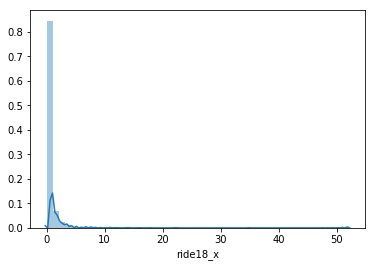

In [6]:
sns.distplot(sample.ride18_x)

In [7]:
busy_station = list(sample.query('ride18_x >= 3').index); busy_station

[9,
 10,
 11,
 13,
 114,
 124,
 126,
 135,
 136,
 141,
 142,
 149,
 185,
 186,
 201,
 207,
 263,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 319,
 320,
 325,
 357,
 358,
 360,
 367,
 423,
 443,
 445,
 447,
 453,
 454,
 481,
 500,
 551,
 557,
 596,
 638,
 652,
 692,
 1090,
 1091,
 1137,
 1169,
 1191,
 1192,
 1253,
 1355,
 1386,
 1397,
 1463,
 1465,
 1471,
 1564,
 1565,
 1579,
 1699,
 1784,
 1919,
 1940,
 1953,
 1974,
 2021,
 2094,
 2114,
 2119,
 2244,
 2494,
 2495,
 2825,
 2844,
 2965,
 2967,
 2971,
 2973,
 3202,
 3270,
 3271,
 3273,
 3275,
 3277,
 3290,
 3350,
 3351,
 3354,
 3362,
 3372,
 3421,
 3448,
 3486,
 3487,
 3514,
 4088,
 6100732,
 6103001,
 6103005,
 6115000,
 6115101]

In [8]:
idx = [x in busy_station for x in df.station_code]

In [9]:
busy_df = df[idx]

In [10]:
busy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39593 entries, 30 to 395381
Data columns (total 65 columns):
id                       39593 non-null int64
date                     39593 non-null object
bus_route_id             39593 non-null int64
in_out                   39593 non-null object
station_code             39593 non-null int64
station_name             39593 non-null object
latitude                 39593 non-null float64
longitude                39593 non-null float64
ride6_x                  39593 non-null float64
ride7                    39593 non-null float64
ride8_x                  39593 non-null float64
ride9_x                  39593 non-null float64
ride10_x                 39593 non-null float64
ride11_x                 39593 non-null float64
off6_x                   39593 non-null float64
off7_x                   39593 non-null float64
off8_x                   39593 non-null float64
off9_x                   39593 non-null float64
off10_x                  39593 non

In [60]:
len(summary)

103

In [62]:
summary = busy_df.groupby('station_code').mean()

In [15]:
import folium

In [78]:
summary

,id,bus_route_id,latitude,longitude,ride6_x,ride7,ride8_x,ride9_x,ride10_x,ride11_x,off6_x,off7_x,off8_x,off9_x,off10_x,off11_x,ride18_x,date_day,date_dayofweek,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,coords_jeju_airpt1,coords_nh,coords_jeju_city1,coords_jeju_rotary,coords_seoquipo,coords_jeju_bt,coords_halla_hospital,coords_jeju_airpt2,coords_jejusi,coords_jeju_city2,coords_jeju_uni,geo_code,center_3,center_1,center_5,center_0,center_4,center_2,crowded,weekend,ride6_y,ride6_y.1,ride8_y,ride9_y,ride10_y,ride11_y,off6_y,off7_y,off8_y,off9_y,off10_y,off11_y,ride18_y
station_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,206235.198300,2.669649e+07,33.48765,126.47726,1.186969,3.728045,2.798867,1.558074,1.807365,1.524079,0.053824,0.266289,0.849858,0.849858,0.821530,0.529745,3.552408,15.549575,2.801700,23.991501,18.913881,2.791501,83.132295,1011.034844,2.526335,0.312092,4.897607,5.292624,26.409574,2.378641,0.296622,2.553155,4.471745,4.864865,8.445718,1.0,36.860558,2.585667,32.289947,8.106674,27.179524,11.126616,1.0,0.260623,1.186969,1.186969,2.798867,1.558074,1.807365,1.524079,0.053824,0.266289,0.849858,0.849858,0.821530,0.529745,3.552408
10,206352.756863,2.602910e+07,33.48709,126.47833,0.058824,0.470588,0.392157,0.760784,0.976471,1.458824,0.086275,0.156863,0.631373,0.733333,0.721569,0.666667,4.023529,15.600000,2.866667,24.048235,19.140000,2.826667,83.303137,1010.990588,2.521760,0.240366,4.818069,5.240914,26.321761,2.356293,0.328722,2.549638,4.398891,4.786791,8.329452,1.0,36.864392,2.580985,32.175856,8.185822,27.091492,11.028385,1.0,0.266667,0.058824,0.058824,0.392157,0.760784,0.976471,1.458824,0.086275,0.156863,0.631373,0.733333,0.721569,0.666667,4.023529
11,200197.279461,2.374498e+07,33.48503,126.48013,0.259259,0.481481,0.488215,0.855219,1.575758,2.461279,0.161616,0.222222,0.195286,0.296296,0.373737,0.350168,7.572391,15.333333,2.821549,24.021886,18.661279,2.790236,83.126599,1011.054882,2.636059,0.187136,4.726781,5.229803,26.055475,2.431972,0.449402,2.666019,4.329299,4.700180,8.083601,1.0,36.769273,2.694625,31.895786,8.291348,26.824923,10.868663,1.0,0.255892,0.259259,0.259259,0.488215,0.855219,1.575758,2.461279,0.161616,0.222222,0.195286,0.296296,0.373737,0.350168,7.572391
13,202725.363036,2.350743e+07,33.48215,126.48240,0.234323,1.574257,0.851485,0.518152,0.801980,0.861386,0.056106,0.191419,0.303630,0.389439,0.372937,0.458746,3.280528,15.435644,2.600660,24.003630,18.443234,2.749175,82.965677,1011.167657,2.843714,0.503294,4.646244,5.257543,25.690089,2.596863,0.755956,2.875726,4.281785,4.626424,7.765387,1.0,36.626436,2.900772,31.520479,8.430107,26.459185,10.676803,1.0,0.204620,0.234323,0.234323,0.851485,0.518152,0.801980,0.861386,0.056106,0.191419,0.303630,0.389439,0.372937,0.458746,3.280528
114,201344.062500,2.402938e+07,33.51531,126.52467,1.343750,4.281250,3.281250,3.937500,3.093750,3.781250,0.093750,0.093750,0.093750,0.281250,0.125000,0.218750,11.031250,15.343750,3.062500,23.918750,24.175000,2.903125,83.834375,1010.718750,3.105717,5.483078,1.848647,0.342930,28.551240,3.063985,5.651311,3.097847,1.622408,1.770886,7.356498,1.0,41.905726,3.056967,31.814339,13.297746,29.295953,7.314401,1.0,0.312500,1.343750,1.343750,3.281250,3.937500,3.093750,3.781250,0.093750,0.093750,0.093750,0.281250,0.125000,0.218750,11.031250
124,207413.077354,2.715942e+07,33.47308,126.54569,1.340807,2.905830,3.161435,2.109865,1.698430,1.708520,0.020179,0.042601,0.132287,0.153587,0.191704,0.197309,3.380045,15.582960,2.831839,23.993834,19.287444,2.777018,83.506166,1011.021637,6.114870,6.416346,3.292979,4.732244,23.724906,5.748956,6.683555,6.139201,3.738060,3.379907,2.316320,1.0,39.541393,6.115541,26.881676,14.171585,24.456073,5.091588,1.0,0.266816,1.340807,1.340807,3.161435,2.109865,1.698430,1.708520,0.020179,0.042601,0.132287,0.153587,0.191704,0.197309,3.380045
126,202494.937269,2.439886e+07,33.48207,126.48535,0.793358,1.870849,1.623616,1.693727,1.239852,1.217712,0.188192,0.269373,0.594096,0.645756,0.608856,0.568266,3.4

In [82]:
map_osm = folium.Map(location=[33.48944, 126.48508], zoom_start= 11)
for i in summary.index:
    folium.CircleMarker([summary.loc[i,'latitude'], summary.loc[i,'longitude']], radius= summary.loc[i,'ride18_x']/5 ,color='red',fill_color='#red', popup= summary.loc[i,'bus_route_id']).add_to(map_osm)
map_osm

In [64]:
train = busy_df.copy()

In [65]:
train.rename(columns = {'ride6_y.1':'ride7_y'}, inplace = True)

In [66]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', 'ride6_x', 'ride7', 'ride8_x', 'ride9_x',
       'ride10_x', 'ride11_x', 'off6_x', 'off7_x', 'off8_x', 'off9_x',
       'off10_x', 'off11_x', 'ride18_x', 'date_day', 'date_dayofweek',
       'date_dayofname', 'temperature', 'precipitation', 'wind_speed',
       'humidity', 'atmospheric_pressure', 'coords_jeju_airpt1', 'coords_nh',
       'coords_jeju_city1', 'coords_jeju_rotary', 'coords_seoquipo',
       'coords_jeju_bt', 'coords_halla_hospital', 'coords_jeju_airpt2',
       'coords_jejusi', 'coords_jeju_city2', 'coords_jeju_uni', 'geo_code',
       'center_3', 'center_1', 'center_5', 'center_0', 'center_4', 'center_2',
       'crowded', 'weekend', 'ride6_y', 'ride7_y', 'ride8_y', 'ride9_y',
       'ride10_y', 'ride11_y', 'off6_y', 'off7_y', 'off8_y', 'off9_y',
       'off10_y', 'off11_y', 'ride18_y', 'city', 'addr', 'road_addr'],
      dtype='object')

In [81]:
train.head(150)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6_x,ride7,ride8_x,ride9_x,ride10_x,ride11_x,off6_x,off7_x,off8_x,off9_x,off10_x,off11_x,ride18_x,date_day,date_dayofweek,date_dayofname,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,coords_jeju_airpt1,coords_nh,coords_jeju_city1,coords_jeju_rotary,coords_seoquipo,coords_jeju_bt,coords_halla_hospital,coords_jeju_airpt2,coords_jejusi,coords_jeju_city2,coords_jeju_uni,geo_code,center_3,center_1,center_5,center_0,center_4,center_2,crowded,weekend,ride6_y,ride7_y,ride8_y,ride9_y,ride10_y,ride11_y,off6_y,off7_y,off8_y,off9_y,off10_y,off11_y,ride18_y,city,addr,road_addr
30,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,1.999639,0.817689,4.14426,4.573099,26.403025,1.769946,1.005035,2.031282,3.720275,4.111514,7.882664,1,37.432854,2.057088,31.926457,8.860019,27.170571,10.398404,1,1,1.139274,1.139274,2.453465,2.231023,2.149835,1.929373,0.619802,1.343234,2.018482,1.70297,1.363696,1.131353,4.178218,제주시,연동,도령로
31,443,2019-09-01,21520000,시외,357,한라병원,33.48944,126.48508,5.0,0.0,3.0,3.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,1.999639,0.817689,4.14426,4.573099,26.403025,1.769946,1.005035,2.031282,3.720275,4.111514,7.882664,1,37.432854,2.057088,31.926457,8.860019,27.170571,10.398404,1,1,1.139274,1.139274,2.453465,2.231023,2.149835,1.929373,0.619802,1.343234,2.018482,1.70297,1.363696,1.131353,4.178218,제주시,연동,도령로
32,548,2019-09-01,21880000,시외,357,한라병원,33.48944,126.48508,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,1.999639,0.817689,4.14426,4.573099,26.403025,1.769946,1.005035,2.031282,3.720275,4.111514,7.882664,1,37.432854,2.057088,31.926457,8.860019,27.170571,10.398404,1,1,1.139274,1.139274,2.453465,2.231023,2.149835,1.929373,0.619802,1.343234,2.018482,1.70297,1.363696,1.131353,4.178218,제주시,연동,도령로
33,862,2019-09-01,22340000,시외,357,한라병원,33.48944,126.48508,0.0,1.0,3.0,0.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,1.999639,0.817689,4.14426,4.573099,26.403025,1.769946,1.005035,2.031282,3.720275,4.111514,7.882664,1,37.432854,2.057088,31.926457,8.860019,27.170571,10.398404,1,1,1.139274,1.139274,2.453465,2.231023,2.149835,1.929373,0.619802,1.343234,2.018482,1.70297,1.363696,1.131353,4.178218,제주시,연동,도령로
34,908,2019-09-01,22360000,시외,357,한라병원,33.48944,126.48508,0.0,2.0,5.0,0.0,2.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,1.999639,0.817689,4.14426,4.573099,26.403025,1.769946,1.005035,2.031282,3.720275,4.111514,7.882664,1,37.432854,2.057088,31.926457,8.860019,27.170571,10.398404,1,1,1.139274,1.139274,2.453465,2.231023,2.149835,1.929373,0.619802,1.343234,2.018482,1.70297,1.363696,1.131353,4.178218,제주시,연동,도령로
35,979,2019-09-01,22440000,시외,357,한라병원,33.48944,126.48508,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,1.999639,0.817689,4.14426,4.573099,26.403025,1.769946,1.005035,2.031282,3.720275,4.111514,7.882664,1,37.432854,2.057088,31.926457,8.860019,27.170571,10.398404,1,1,1.139274,1.139274,2.453465,2.231023,2.149835,1.929373,0.619802,1.343234,2.018482,1.70297,1.363696,1.131353,4.178218,제주시,연동,도령로
36,1293,2019-09-01,22540000,시외,357,한라병원,33.48944,126.48508,6.0,5.0,11.0,19.0,10.0,5.0,0.0,0.0,2.0,1.0,0.0,1.0,12.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,1.999639,0.817689,4.14426,4.573099,26.403025,1.769946,1.005035,2.031282,3.720275,4.111514,7.882664,1,37.432854,2.057088,31.926457,8.860019,27.170571,10.398404,1,1,1.139274,1.139274,2.453465,2.231023,2.149835,1.929373,0.619802,1.343234,2.018482,1.70297,1.363696,1.131353,4.178218,제주시,연동,도령로
37,1415,2019-09-01,22560000,시외,357,한라병원,33.48944,126.48508,13.0,7.0,3.0,9.0,5.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,12.0,1,6,Sunday,23.3,26.1,2.0,80.6,1014.3,1.999639,0.817689,4.14426,4.573099,26.403025,1.769946,1.005035,2.031282,3.720275,4.111514,7.882664,1,37.432854,2.057088,

In [67]:
len(train.bus_route_id.unique()), len(train.station_code.unique())

(473, 103)

### 노선, 역별 ride 18
- 같은 station_code라고 해도, 노선에 따라 큰 차이를 보인다

In [68]:
new_ = train.groupby(['station_code', 'bus_route_id']).mean()['ride18_x'].reset_index()

In [96]:
new_.head()

,station_code,bus_route_id,ride18_x
0,9,23040000,9.033333
1,9,23110000,3.466667
2,9,23130000,0.482759
3,9,23220000,15.833333
4,9,23250000,0.000000


In [97]:
busy_busy = new_.query('ride18_x >= 10')
terrible_station = list(busy_busy.station_code.unique())
terrible_station, len(terrible_station)

([9,
  10,
  11,
  13,
  114,
  124,
  126,
  135,
  136,
  142,
  149,
  185,
  186,
  201,
  207,
  263,
  278,
  279,
  280,
  282,
  283,
  284,
  319,
  320,
  325,
  357,
  358,
  360,
  367,
  423,
  443,
  445,
  447,
  481,
  557,
  596,
  638,
  652,
  1091,
  1137,
  1169,
  1355,
  1471,
  1564,
  1565,
  1579,
  1699,
  1784,
  1919,
  1940,
  1953,
  1974,
  2021,
  2114,
  2494,
  2495,
  2971,
  2973,
  3202,
  3270,
  3271,
  3273,
  3275,
  3277,
  3290,
  3350,
  3351,
  3448,
  3486,
  3514,
  4088,
  6100732,
  6103001,
  6103005,
  6115101],
 75)

In [99]:
busy_busy.groupby('station_code').count()

,bus_route_id,ride18_x
station_code,,
9,2,2
10,2,2
11,2,2
13,2,2
114,1,1
124,2,2
126,2,2
135,1,1
136,1,1


In [90]:
idx = [x in terrible_station for x in summary.index]

In [93]:
terribles = summary[idx]

In [94]:
map_osm = folium.Map(location=[33.48944, 126.48508], zoom_start= 11)
for i in terribles.index:
    folium.CircleMarker([terribles.loc[i,'latitude'], terribles.loc[i,'longitude']], radius= terribles.loc[i,'ride18_x']/5 ,color='red',fill_color='#red', popup= terribles.loc[i,'bus_route_id']).add_to(map_osm)
map_osm

In [ ]:
map_osm = folium.Map(location=[33.48944, 126.48508], zoom_start= 11)
for i in busy_busy.index:
    folium.CircleMarker([busy_busy.loc[i,'latitude'], busy_busy.loc[i,'longitude']], radius= summary.loc[i,'ride18_x']/5 ,color='red',fill_color='#red', popup= summary.loc[i, 'station_name']).add_to(map_osm)
map_osm

In [109]:
new_.query('station_code == 9').ride18_x.var()

21.09647152083188

In [ ]:
pd.pivot_table()

In [69]:
cols = list(train.columns)
cate = ['addr','city','road_addr','in_out','geo_code','crowded','weekend']
[cols.remove(cat) for cat in cate]
unnecessary = ['id','date','bus_route_id','station_code','station_name','latitude','longitude','date_dayofname','date_day','date_dayofweek','ride18_x','ride18_y']
[cols.remove(un) for un in unnecessary]
var = cols
# var.remove('precipitation')
var_scale = ["scale({})".format(name) for name in var]
var_scale


['scale(ride6_x)',
 'scale(ride7)',
 'scale(ride8_x)',
 'scale(ride9_x)',
 'scale(ride10_x)',
 'scale(ride11_x)',
 'scale(off6_x)',
 'scale(off7_x)',
 'scale(off8_x)',
 'scale(off9_x)',
 'scale(off10_x)',
 'scale(off11_x)',
 'scale(temperature)',
 'scale(precipitation)',
 'scale(wind_speed)',
 'scale(humidity)',
 'scale(atmospheric_pressure)',
 'scale(coords_jeju_airpt1)',
 'scale(coords_nh)',
 'scale(coords_jeju_city1)',
 'scale(coords_jeju_rotary)',
 'scale(coords_seoquipo)',
 'scale(coords_jeju_bt)',
 'scale(coords_halla_hospital)',
 'scale(coords_jeju_airpt2)',
 'scale(coords_jejusi)',
 'scale(coords_jeju_city2)',
 'scale(coords_jeju_uni)',
 'scale(center_3)',
 'scale(center_1)',
 'scale(center_5)',
 'scale(center_0)',
 'scale(center_4)',
 'scale(center_2)',
 'scale(ride6_y)',
 'scale(ride7_y)',
 'scale(ride8_y)',
 'scale(ride9_y)',
 'scale(ride10_y)',
 'scale(ride11_y)',
 'scale(off6_y)',
 'scale(off7_y)',
 'scale(off8_y)',
 'scale(off9_y)',
 'scale(off10_y)',
 'scale(off11_y)']

In [73]:
len(train)

39593

In [70]:
len(train.station_code.unique())

103

In [96]:
model = sm.OLS.from_formula(
    'ride18_x ~ C(station_code) + C(bus_route_id) + C(weekend) + C(crowded) +'+'+'.join(var_scale), data=train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               ride18_x   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     98.98
Date:                Fri, 27 Mar 2020   Prob (F-statistic):               0.00
Time:                        03:03:29   Log-Likelihood:            -1.3836e+05
No. Observations:               39593   AIC:                         2.779e+05
Df Residuals:                   39001   BIC:                         2.830e+05
Df Model:                         591                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [79]:
result.resid.mean()

0.0011489275528927985